In [1]:
import bioframe as bf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from tqdm import tqdm
from scipy.stats import spearmanr, mannwhitneyu, fisher_exact
from scipy.special import expit as sigmoid
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

In [3]:
!ls output/variants/all/vep

scratch


In [4]:
models = [
    #"ConvNet_batch2048_weight1.0_secondpart_30k",
    "ConvNet_batch2048_secondpart_30k",
    #"ConvNet_batch2048_weight0_secondpart_30k",
    "vep/scratch/users/gbenegas/checkpoints/GPN_Arabidopsis_multispecies/ConvNet_ss_12k/checkpoint-12000",
    #"phyloP",
    #"phastCons",
]
model_renaming = {
    #"ConvNet_batch2048_secondpart_30k": "GPN",
    #"ConvNet_batch2048_weight1.0_secondpart_30k": "repeat-weight-1",
    #"ConvNet_batch2048_secondpart_30k": "repeat-weight-0.1",
    #"ConvNet_batch2048_weight0_secondpart_30k": "repeat-weight-0",
    "ConvNet_batch2048_secondpart_30k": "8 species",
    "vep/scratch/users/gbenegas/checkpoints/GPN_Arabidopsis_multispecies/ConvNet_ss_12k/checkpoint-12000": "1 species",
}

In [5]:
d = Path(f"output/variants/all")
variants = pd.read_parquet(d / "variants.parquet")

for m in models:
    model_path = d / f"{m}.parquet"
    model_name = model_renaming.get(m, m)
    variants[model_name] = pd.read_parquet(model_path)["score"].values
variants

,chrom,pos,ref,alt,AC,AF,consequence,8 species,1 species
0,1,266,G,A,82,0.040414,intergenic_variant,-0.670362,-0.251338
1,1,270,G,A,16,0.007886,intergenic_variant,-0.406548,-0.344978
2,1,276,T,G,16,0.007886,intergenic_variant,-0.643284,0.059943
3,1,284,T,A,1,0.000493,intergenic_variant,-0.779196,-0.729820
4,1,286,T,A,1,0.000493,intergenic_variant,-0.048531,-0.465444
...,...,...,...,...,...,...,...,...,...
10697059,5,26975233,C,G,1,0.000493,intergenic_variant,-4.791409,-0.808084
10697060,5,26975235,G,A,11,0.005421,intergenic_variant,-1.822485,0.744265
10697061,5,26975240,C,T,4,0.001971,intergenic_variant,-3.438794,-0.797683
10697062,5,26975245,G,A,7,0.003450,intergenic_variant,-2.521554,-0.278273


In [6]:
variants.consequence = variants.consequence.str.replace("_variant", "")
variants

,chrom,pos,ref,alt,AC,AF,consequence,8 species,1 species
0,1,266,G,A,82,0.040414,intergenic,-0.670362,-0.251338
1,1,270,G,A,16,0.007886,intergenic,-0.406548,-0.344978
2,1,276,T,G,16,0.007886,intergenic,-0.643284,0.059943
3,1,284,T,A,1,0.000493,intergenic,-0.779196,-0.729820
4,1,286,T,A,1,0.000493,intergenic,-0.048531,-0.465444
...,...,...,...,...,...,...,...,...,...
10697059,5,26975233,C,G,1,0.000493,intergenic,-4.791409,-0.808084
10697060,5,26975235,G,A,11,0.005421,intergenic,-1.822485,0.744265
10697061,5,26975240,C,T,4,0.001971,intergenic,-3.438794,-0.797683
10697062,5,26975245,G,A,7,0.003450,intergenic,-2.521554,-0.278273


In [7]:
models = [model_renaming.get(m, m) for m in models]
models

['8 species', '1 species']

In [8]:
variants = variants.query("AF < 0.5")
variants

,chrom,pos,ref,alt,AC,AF,consequence,8 species,1 species
0,1,266,G,A,82,0.040414,intergenic,-0.670362,-0.251338
1,1,270,G,A,16,0.007886,intergenic,-0.406548,-0.344978
2,1,276,T,G,16,0.007886,intergenic,-0.643284,0.059943
3,1,284,T,A,1,0.000493,intergenic,-0.779196,-0.729820
4,1,286,T,A,1,0.000493,intergenic,-0.048531,-0.465444
...,...,...,...,...,...,...,...,...,...
10697059,5,26975233,C,G,1,0.000493,intergenic,-4.791409,-0.808084
10697060,5,26975235,G,A,11,0.005421,intergenic,-1.822485,0.744265
10697061,5,26975240,C,T,4,0.001971,intergenic,-3.438794,-0.797683
10697062,5,26975245,G,A,7,0.003450,intergenic,-2.521554,-0.278273


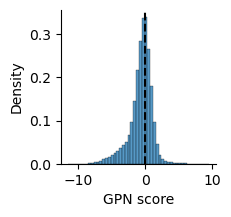

In [7]:
plt.figure(figsize=(2,2))
sns.histplot(
    data=variants,
    x="GPN",
    bins=50,
    stat="density",
)
plt.axvline(0, linestyle="--", color="black")
plt.xlabel("GPN score")
sns.despine();
#plt.savefig("output/plots/gpn_score_hist.svg", bbox_inches="tight")

/tmp/ipykernel_3897213/1240158466.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variants["bin"] = pd.cut(variants.GPN, bins)
/tmp/ipykernel_3897213/1240158466.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variants["bin_midpoint"] = variants.bin.apply(lambda x: x.mid)


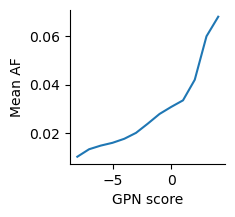

In [8]:
#bins = np.linspace(-8, 5)
bins = np.arange(-8.5, 5.5)
variants["bin"] = pd.cut(variants.GPN, bins)
variants["bin_midpoint"] = variants.bin.apply(lambda x: x.mid)
plt.figure(figsize=(2,2))
g = sns.lineplot(
    data=variants,
    x="bin_midpoint",
    y="AF",
    errorbar=None,
)
plt.xlabel("GPN score")
plt.ylabel("Mean AF")
sns.despine();
#plt.savefig("output/plots/gpn_score_vs_af.svg", bbox_inches="tight")

/tmp/ipykernel_3897213/1127134688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variants["GPN score"] = variants.bin


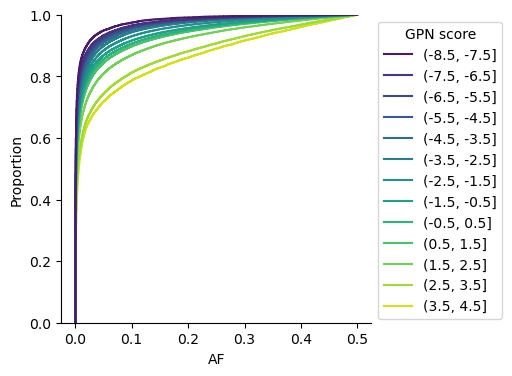

In [9]:
variants["GPN score"] = variants.bin
plt.figure(figsize=(4,4))
g = sns.ecdfplot(
    data=variants,#df[df["GPN score percentile bin"].isin([1, 50, 100])],
    hue="GPN score",
    x="AF",
    palette="viridis",
    #stat="probability",
    #bins=10,
    #multiple="dodge",
)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.despine()
#plt.savefig("output/plots/gpn_score_vs_af_cdf.pdf", bbox_inches="tight")

In [10]:
repeats = pd.read_csv("input/repeats.bed.gz", sep="\t").rename(columns=dict(genoName="chrom", genoStart="start", genoEnd="end"))
repeats.chrom = repeats.chrom.str.replace("Chr", "")
repeats

,#bin,swScore,milliDiv,milliDel,milliIns,chrom,start,end,genoLeft,strand,repName,repClass,repFamily,repStart,repEnd,repLeft,id
0,10,444,191,54,76,1,12582773,12582920,-17844751,-,Helitron1,RC,Helitron,-9953,5856,5713,5
1,10,6899,30,0,1,1,13630758,13631561,-16796110,-,ATENSPM2,DNA,CMC-EnSpm,-6268,1985,1184,6
2,10,2521,72,3,2,1,14676131,14685672,-15741999,-,AR3,Satellite,Satellite,-73,9553,1,6
3,10,6227,45,48,6,1,15728234,15729041,-14698630,+,ATCopia95LTR,LTR,Copia,1,841,0,8
4,11,537,291,44,131,1,18873944,18874466,-11553205,-,Atlantys3_LTR,LTR,Gypsy,-12,482,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69340,587,238,156,0,0,M,361356,361401,-5523,-,SSU-rRNA_Ath,rRNA,rRNA,-16,1886,1842,6
69341,587,278,263,0,0,M,361523,361599,-5325,-,SSU-rRNA_Ath,rRNA,rRNA,-164,1738,1663,6
69342,587,582,289,31,44,M,362179,362407,-4517,-,SSU-rRNA_Ath,rRNA,rRNA,-481,1421,1197,6
69343,587,336,258,62,42,M,364854,365016,-1908,+,LSU-rRNA_Ath,rRNA,rRNA,797,961,-2414,6


In [11]:
variants["start"] = variants.pos
variants["end"] = variants.start + 1
variants = bf.coverage(variants, repeats).rename(columns={"coverage": "repeat"})
variants.repeat = variants.repeat.astype(bool)
variants

/tmp/ipykernel_3897213/3514059738.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variants["start"] = variants.pos
/tmp/ipykernel_3897213/3514059738.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variants["end"] = variants.start + 1


,chrom,pos,ref,alt,AC,AF,consequence,GPN,phyloP,phastCons,bin,bin_midpoint,GPN score,start,end,repeat
0,1,266,G,A,82,0.040414,intergenic,-0.670362,0.813899,-0.000523,"(-1.5, -0.5]",-1.0,"(-1.5, -0.5]",266,267,False
1,1,270,G,A,16,0.007886,intergenic,-0.406548,0.097275,-0.007196,"(-0.5, 0.5]",0.0,"(-0.5, 0.5]",270,271,False
2,1,276,T,G,16,0.007886,intergenic,-0.643284,0.493032,-0.000789,"(-1.5, -0.5]",-1.0,"(-1.5, -0.5]",276,277,False
3,1,284,T,A,1,0.000493,intergenic,-0.779196,0.703100,-0.000292,"(-1.5, -0.5]",-1.0,"(-1.5, -0.5]",284,285,False
4,1,286,T,A,1,0.000493,intergenic,-0.048531,1.644564,-0.000070,"(-0.5, 0.5]",0.0,"(-0.5, 0.5]",286,287,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10305055,5,26975233,C,G,1,0.000493,intergenic,-4.791409,-0.773075,-0.285819,"(-5.5, -4.5]",-5.0,"(-5.5, -4.5]",26975233,26975234,False
10305056,5,26975235,G,A,11,0.005421,intergenic,-1.822485,-0.267246,-0.259101,"(-2.5, -1.5]",-2.0,"(-2.5, -1.5]",26975235,26975236,False
10305057,5,26975240,C,T,4,0.001971,intergenic,-3.438794,-0.764734,-0.229109,"(-3.5, -2.5]",-3.0,"(-3.5, -2.5]",26975240,26975241,False
10305058,5,26975245,G,A,7,0.003450,intergenic,-2.521554,-0.862251,-0.094685,"(-3.5, -2.5]",-3.0,"(-3.5, -2.5]",26975245,26975246,False


In [12]:
variants.repeat.value_counts()

False    7906478
True     2398582
Name: repeat, dtype: int64

In [9]:
consequences = [
    'all',
    #'repeat',
]
specific_consequences = variants.consequence.value_counts()[:8].index.values.tolist()
consequences += specific_consequences
consequences

['all',
 'intergenic',
 'intron',
 'missense',
 'synonymous',
 'upstream_gene',
 'downstream_gene',
 '3_prime_UTR',
 '5_prime_UTR']

In [10]:
# conservation scores undefined in unaligned regions
# could additionally evaluate results without conservation scores
variants.dropna(inplace=True)
variants

/tmp/ipykernel_99539/3668342684.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variants.dropna(inplace=True)


,chrom,pos,ref,alt,AC,AF,consequence,8 species,1 species
0,1,266,G,A,82,0.040414,intergenic,-0.670362,-0.251338
1,1,270,G,A,16,0.007886,intergenic,-0.406548,-0.344978
2,1,276,T,G,16,0.007886,intergenic,-0.643284,0.059943
3,1,284,T,A,1,0.000493,intergenic,-0.779196,-0.729820
4,1,286,T,A,1,0.000493,intergenic,-0.048531,-0.465444
...,...,...,...,...,...,...,...,...,...
10697059,5,26975233,C,G,1,0.000493,intergenic,-4.791409,-0.808084
10697060,5,26975235,G,A,11,0.005421,intergenic,-1.822485,0.744265
10697061,5,26975240,C,T,4,0.001971,intergenic,-3.438794,-0.797683
10697062,5,26975245,G,A,7,0.003450,intergenic,-2.521554,-0.278273


In [15]:
from scipy.stats import pearsonr, spearmanr

for model in ["phyloP", "phastCons"]:
    print(model)
    print(pearsonr(variants["GPN"], variants[model]))
    print(spearmanr(variants["GPN"], variants[model]))

phyloP
PearsonRResult(statistic=0.22619744507417752, pvalue=0.0)
SpearmanrResult(correlation=0.1962338480288296, pvalue=0.0)
phastCons
PearsonRResult(statistic=0.1276288054104526, pvalue=0.0)
SpearmanrResult(correlation=0.12637284836269672, pvalue=0.0)


In [11]:
variants["Status"] = "Neither"
variants.loc[variants.AC == 1, "Status"] = "Rare"
variants.loc[variants.AF >= 0.05, "Status"] = "Common"
variants = variants[variants.Status!="Neither"]
variants.Status = variants.Status.astype('category')
variants.Status.value_counts()

/tmp/ipykernel_99539/867144211.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variants["Status"] = "Neither"
/tmp/ipykernel_99539/867144211.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variants.Status = variants.Status.astype('category')


Status
Rare      3533596
Common    1418192
Name: count, dtype: int64

In [12]:
from math import sqrt

def compute_odds_ratio(df, threshold_quantile, model_name):
    df = df.copy()
    threshold = df[model_name].quantile(threshold_quantile)
    df.loc[df[model_name] <= threshold, "ModelScoreTier"] = "Low" 
    df.loc[df[model_name] > df[model_name].quantile(0.1), "ModelScoreTier"] = "High"
    #df.loc[df[model_name] > threshold, "ModelScoreTier"] = "High"
    df = df[df.ModelScoreTier.isin(["Low", "High"])]
    
    df.ModelScoreTier = df.ModelScoreTier.astype('category')
    group_counts = df.groupby(["Status", "ModelScoreTier"]).size()
    log_odds_se = sqrt(sum(1/group_counts)) # "All of statistics" eq. 15.7
    group_counts2 = group_counts.copy()
    #print(group_counts2)
    group_counts = group_counts.loc[pd.MultiIndex.from_tuples(
        [['Common', 'High'],
         ['Common', 'Low'],
         ['Rare', 'High'],
         ['Rare', 'Low']]
    )].values.reshape((2,2))
    min_counts = group_counts.min()
    odds_ratio, p_value = fisher_exact(group_counts, alternative='greater')
    log_odds_ratio = np.log(odds_ratio)
    ci_lower = np.exp(log_odds_ratio-2*log_odds_se)
    ci_upper = np.exp(log_odds_ratio+2*log_odds_se)
    # [ci_lower, ci_upper] is 95% CI
    if np.isinf(odds_ratio):
        print(odds_ratio, p_value, group_counts2)
    return odds_ratio, p_value, min_counts, ci_lower, ci_upper

In [13]:
def get_subtitle(consequence, n_rare, n_common):
    c = consequence.replace("_variant", "")
    return f"{c}\nn={n_rare} vs. {n_common}"

threshold_quantiles = [
    1e-3,
    1e-2,
    1e-1
]


rows = []
for c in consequences:
    if c == "all":
        df_c = variants.copy()
    elif c == "repeat":
        df_c = variants[variants.repeat].copy()
    else:
        df_c = variants[variants.consequence==c].copy()
    df_c.dropna(subset=models, inplace=True)
    for m in models:
        subtitle = get_subtitle(c, (df_c.Status=="Rare").sum(), (df_c.Status=="Common").sum())
        for tq in threshold_quantiles:
            print(c, m, tq)
            #if tq == 1e-4 and c != "all": continue
            OR, p_value, min_counts, cil, ciu = compute_odds_ratio(df_c, tq, m)
            rows.append([m, c, tq, OR, p_value, min_counts, cil, ciu, subtitle])
results = pd.DataFrame(rows, columns=["Model", "Consequence", "Threshold quantile", "Odds ratio", "p_value", "min_counts", "cil", "ciu", "subtitle"])
results

all 8 species 0.001
all 8 species 0.01
all 8 species 0.1
all 1 species 0.001
all 1 species 0.01
all 1 species 0.1
intergenic 8 species 0.001
intergenic 8 species 0.01
intergenic 8 species 0.1
intergenic 1 species 0.001
intergenic 1 species 0.01
intergenic 1 species 0.1
intron 8 species 0.001
intron 8 species 0.01
intron 8 species 0.1
intron 1 species 0.001
intron 1 species 0.01
intron 1 species 0.1
missense 8 species 0.001
missense 8 species 0.01
missense 8 species 0.1
missense 1 species 0.001
missense 1 species 0.01
missense 1 species 0.1
synonymous 8 species 0.001
synonymous 8 species 0.01
synonymous 8 species 0.1
synonymous 1 species 0.001
synonymous 1 species 0.01
synonymous 1 species 0.1
upstream_gene 8 species 0.001
upstream_gene 8 species 0.01
upstream_gene 8 species 0.1
upstream_gene 1 species 0.001
upstream_gene 1 species 0.01
upstream_gene 1 species 0.1
downstream_gene 8 species 0.001
downstream_gene 8 species 0.01
downstream_gene 8 species 0.1
downstream_gene 1 species 0.001

,Model,Consequence,Threshold quantile,Odds ratio,p_value,min_counts,cil,ciu,subtitle
0,8 species,all,0.001,4.598271,4.933793e-296,419,4.151780,5.092779,all\nn=3533596 vs. 1418192
1,8 species,all,0.010,2.958696,0.000000e+00,6220,2.879308,3.040272,all\nn=3533596 vs. 1418192
2,8 species,all,0.100,1.940967,0.000000e+00,88955,1.926102,1.955946,all\nn=3533596 vs. 1418192
3,1 species,all,0.001,2.349867,2.116498e-124,754,2.171080,2.543377,all\nn=3533596 vs. 1418192
4,1 species,all,0.010,2.388522,0.000000e+00,7436,2.328980,2.449586,all\nn=3533596 vs. 1418192
5,1 species,all,0.100,1.766410,0.000000e+00,95498,1.753218,1.779701,all\nn=3533596 vs. 1418192
6,8 species,intergenic,0.001,2.291741,8.365559e-56,348,2.040949,2.573349,intergenic\nn=1773285 vs. 648449
7,8 species,intergenic,0.010,2.139224,0.000000e+00,3690,2.063811,2.217392,intergenic\nn=1773285 vs. 648449
8,8 species,intergenic,0.100,1.775773,0.000000e+00,43107,1.756264,1.795498,intergenic\nn=1773285 vs. 648449
9,1 species,intergenic,0.001,2.226444,9.418391e-53,357,1.985219,2.496980,intergenic\nn=1773285 vs. 648449


In [14]:
results["Odds ratio"].max()  # careful with inf

7.905667234454055

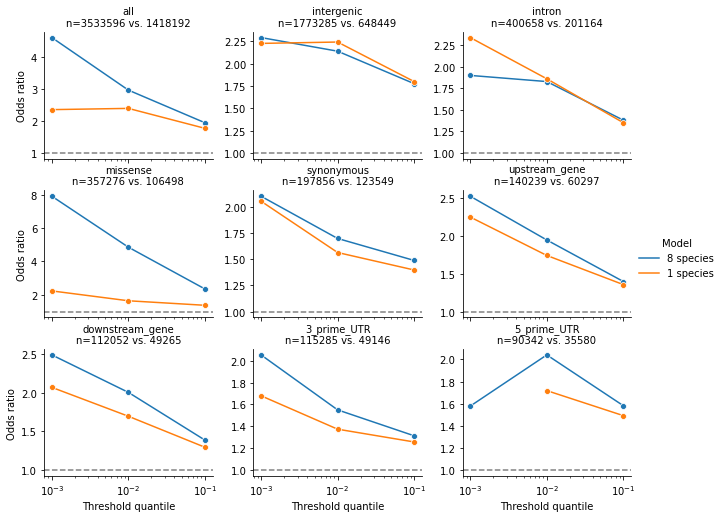

In [15]:
g = sns.relplot(
    data=results[(results.p_value<=0.05)],
    x="Threshold quantile",
    y="Odds ratio",
    hue="Model",
    hue_order=models,
    col="subtitle",
    height=3,
    kind="line",
    marker="o",
    col_wrap=3,
    facet_kws={'sharey': False, 'sharex': True},
)
for ax in g.axes: ax.axhline(1, ls='--', color="grey")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set(xscale='log');
g.fig.subplots_adjust(top=0.75)
#plt.savefig("output/plots/rare_vs_common_line.pdf", bbox_inches='tight')

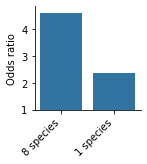

In [19]:
plt.figure(figsize=(1.9,1.9))
g = sns.barplot(
    data=results[(results.p_value<=0.05)&(results["Threshold quantile"]==1e-3)&(results.Consequence=="all")],
    y="Odds ratio",
    x="Model",
    color="C0",
);
g.set(ylim=(1))
sns.despine()
plt.xlabel("");
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right');
#plt.savefig("output/plots/rare_vs_common_bar.svg", bbox_inches='tight');
#plt.savefig("output/plots/rare_vs_common_bar_repeat_weight.svg", bbox_inches='tight');
#plt.savefig("output/plots/rare_vs_common_bar_1_vs_0.01.svg", bbox_inches='tight');
#plt.savefig("output/plots/rare_vs_common_bar_5_vs_0.05.svg", bbox_inches='tight');
#plt.savefig("output/plots/rare_vs_common_bar_n_species.svg", bbox_inches='tight');

In [17]:
results[(results.p_value<=0.05) & (results["Threshold quantile"]==1e-3) & (results.Consequence=="all")]

,Model,Consequence,Threshold quantile,Odds ratio,p_value,min_counts,cil,ciu,subtitle
0,8 species,all,0.001,4.598271,4.933793e-296,419,4.15178,5.092779,all\nn=3533596 vs. 1418192
3,1 species,all,0.001,2.349867,2.116498e-124,754,2.17108,2.543377,all\nn=3533596 vs. 1418192
